In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

In [3]:
# Dinh nghia ham ACF va PACF
def sACF(y,K):
    T = len(y)
    ytb = y.mean()
    ACF = np.zeros(K)
    c0 = np.sum((y-ytb)**2)/T
    for k in range(1, K+1):
        ck = np.sum((y-ytb)[:T-k]*(y-ytb)[k:T])/T
        ACF[k-1]= ck/c0
    
    se_ACF = np.zeros(K)
    for i in range(K):
        se_ACF[i] = np.sqrt(1/T*(1+2*np.sum(ACF[:i]**2)))
    return ACF, se_ACF

def sPACF(y,K):
    T = len(y)
    #Lay day dau tien
    ACF = sACF(y,K)[0]
    PACF = np.zeros(K)
    for m in range(1,K+1):
        P = np.eye(m)
        for i in range(m):
            for j in range(i):
                P[i,j] = ACF[i-j-1]
            for j in range(i+1,m):
                P[i,j] = ACF[j-i-1];
        PACF[m-1] = np.linalg.solve(P,ACF[:m])[-1]
    se_PACF = np.array([1/np.sqrt(T) for i in range(K)])
    return PACF, se_PACF


In [7]:
# Đọc dữ liệu
data = pd.read_excel('data.xlsx')
y = data['yt'].values
y

array([29, 20, 25, 29, 31, 33, 34, 27, 26, 30, 29, 28, 28, 26, 27, 26, 30,
       28, 26, 30, 31, 30, 37, 30, 33, 31, 27, 33, 37, 29, 28, 30, 29, 34,
       30, 20, 17, 23, 24, 34, 36, 35, 33, 29, 25, 27, 30, 29, 28, 32])

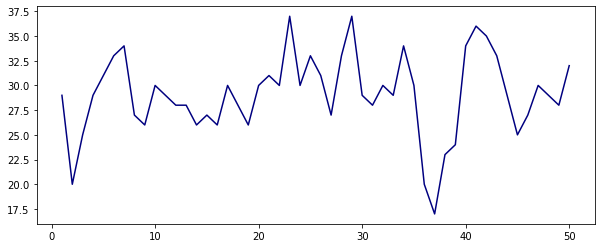

In [11]:
#    Vẽ biểu đồ
fig, ax = plt.subplots(figsize = (10,4))
ax.plot(data['Period'], data['yt'], color='navy')
plt.show()

Trung bình = 29.060000, phương sai = 16.736400
Độ lêch tiêu chuẩn = 4.091015


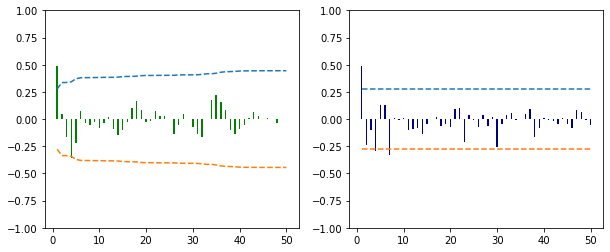

In [12]:
# Tính trung bình, phương sai, độ lệch tiêu chuẩn
y= data['yt'].values
T = len(y)
ytb = y.mean()
var_yt = np.sum((y-ytb)**2)/T
s_y = np.sqrt(var_yt)
print("Trung bình = %f, phương sai = %f" %(ytb, var_yt))
print("Độ lêch tiêu chuẩn = %f" %(s_y))

# Tính ACF: rk và se(rk) (sai số tiêu chuẩn)
K = 50
ACF, se_ACF = sACF(y,K)

# Tính PACF: Pkk và se(pkk) (sai số tiêu chuẩn)
PACF, se_PACF = sPACF(y,K)

# Vẽ đồ thị
fig,ax = plt.subplots(1,2,figsize = (10,4))
x = np.arange(1,K+1)
ax[0].bar(x, ACF, color='green', width = 0.3, label='ACF')
ax[0].plot(x, 1.96*se_ACF, linestyle='dashed')
ax[0].plot(x, -1.96*se_ACF, linestyle='dashed')
ax[0].set_ylim([-1, 1])


ax[1].bar(x, PACF, color='navy', width = 0.3, label='PACF')
ax[1].plot(x, 1.96*se_PACF, linestyle='dashed')
ax[1].plot(x, -1.96*se_PACF, linestyle='dashed')
ax[1].set_ylim([-1, 1])

plt.show()

Nhận xét: Có thể là mô hình AR(1) Hoặc MA(1)

#### Ước lượng mô hình AR(1)

In [23]:
# ƯỚc lượng tham số
from sklearn.linear_model import LinearRegression
xdata = y[:-1]
ydata = y[1:]

#fit_intercept=False: luôn đi qua gốc toạ độ, không có hệ số tự do
model = LinearRegression(fit_intercept=False)

# Chuyển xdata thành ma trận
X = xdata[:, np.newaxis]
#Khớp 2 cái lại với nhau 
model.fit(X,ydata)
print("Tham so beta", model.coef_)

# Sai số tiêu chuẩn của ước lượng tham số mô hình
at = ydata - model.predict(X)
sigma = np.sqrt(np.sum(at**2)/(len(at)-1))
se_beta = sigma*np.sqrt(np.diag(np.linalg.inv(X.T@X)))
print("Sai số tiêu chuẩn của beta", se_beta)
print("Sigma = ", sigma)


Tham so beta [0.99200704]
Sai số tiêu chuẩn của beta [0.02055244]
Sigma =  4.213852072618504


In [25]:
#Đánh giá mô hình bằng hệ số xác định (R^2) và thống kê Q(k)
#biến thiên sai số
SE = np.sum(at**2)
# biến thiên tổng thể
ST = np.sum((ydata - ydata.mean())**2)

R2 = 1 - SE/ST
# R2 giải thích độ biến thiên của 4% dữ liệu
print('R2', R2)


R2 -0.018520240217327455


In [26]:
# Tính thống kê Q(k)
def Qstat(at,k):
    at_ACF = sACF(at,k)[0]
    n = len(at)
    Qstat = 0
    for i in range(k):
        Qstat += n*(n+2)*at_ACF[i]**2/(n-i-1)
    return Qstat

k = 12
print("Giá trị thống kê Q(%d) = %f" %(k,Qstat(at,k)))
    

Giá trị thống kê Q(12) = 21.724479
